## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Импорт библиотек </h1> 

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from bayes_opt import BayesianOptimization


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Загрузка данных и удаление выбросов </h1> 

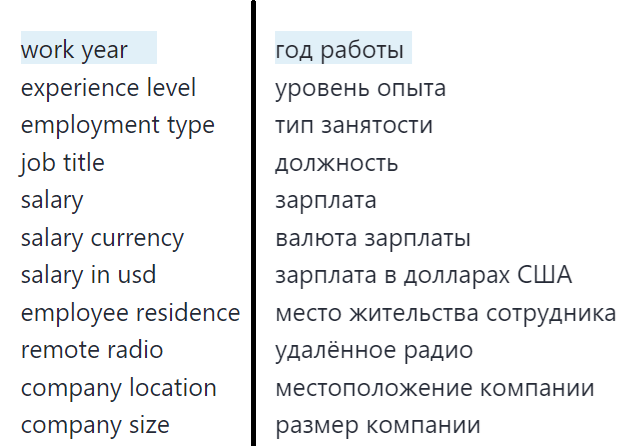
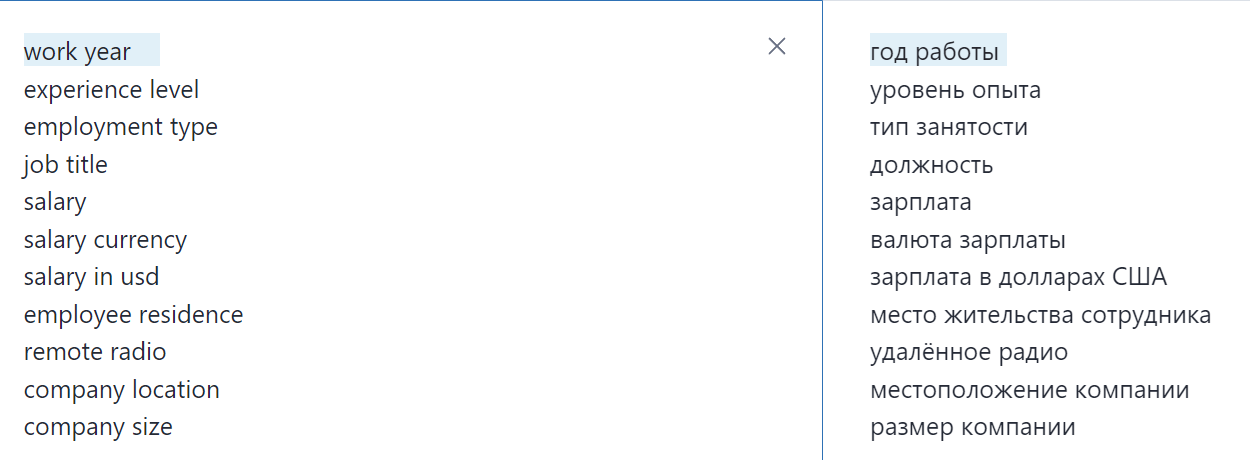

In [85]:
df = pd.read_csv('ds_salaries.csv')

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers(df, 'work_year')
df = remove_outliers(df, 'salary')
df = remove_outliers(df, 'salary_in_usd')

df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3745,2021,SE,FT,Director of Data Science,168000,USD,168000,JP,0,JP,S
3746,2021,MI,FT,Data Scientist,160000,SGD,119059,SG,100,IL,M
3748,2021,MI,FT,Data Engineer,24000,EUR,28369,MT,50,MT,L
3749,2021,SE,FT,Data Specialist,165000,USD,165000,US,100,US,L


In [3]:
print("Размер датасета:", df.shape)
print("Пропущенные значения:")
print(df.isnull().sum())


Размер датасета: (3547, 11)
Пропущенные значения:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> EDA </h1> 

In [4]:
pd.concat([df.dtypes, df.nunique()], axis=1).rename(columns={0: "Type", 1: "Number of unique"})

,Type,Number of unique
work_year,int64,3
experience_level,object,4
employment_type,object,4
job_title,object,87
salary,int64,712
salary_currency,object,12
salary_in_usd,int64,897
employee_residence,object,74
remote_ratio,int64,3
company_location,object,67


In [5]:
df.describe().T.style.background_gradient(cmap='YlOrRd')

,count,mean,std,min,25%,50%,75%,max
work_year,3547.000000,2022.429095,0.598672,2021.000000,2022.000000,2022.000000,2023.000000,2023.000000
salary,3547.000000,136592.408796,56160.497577,6000.000000,100000.000000,135000.000000,175000.000000,286000.000000
salary_in_usd,3547.000000,136778.999154,55711.995039,5132.000000,100000.000000,135000.000000,175000.000000,286000.000000
remote_ratio,3547.000000,45.573724,48.802662,0.000000,0.000000,0.000000,100.000000,100.000000


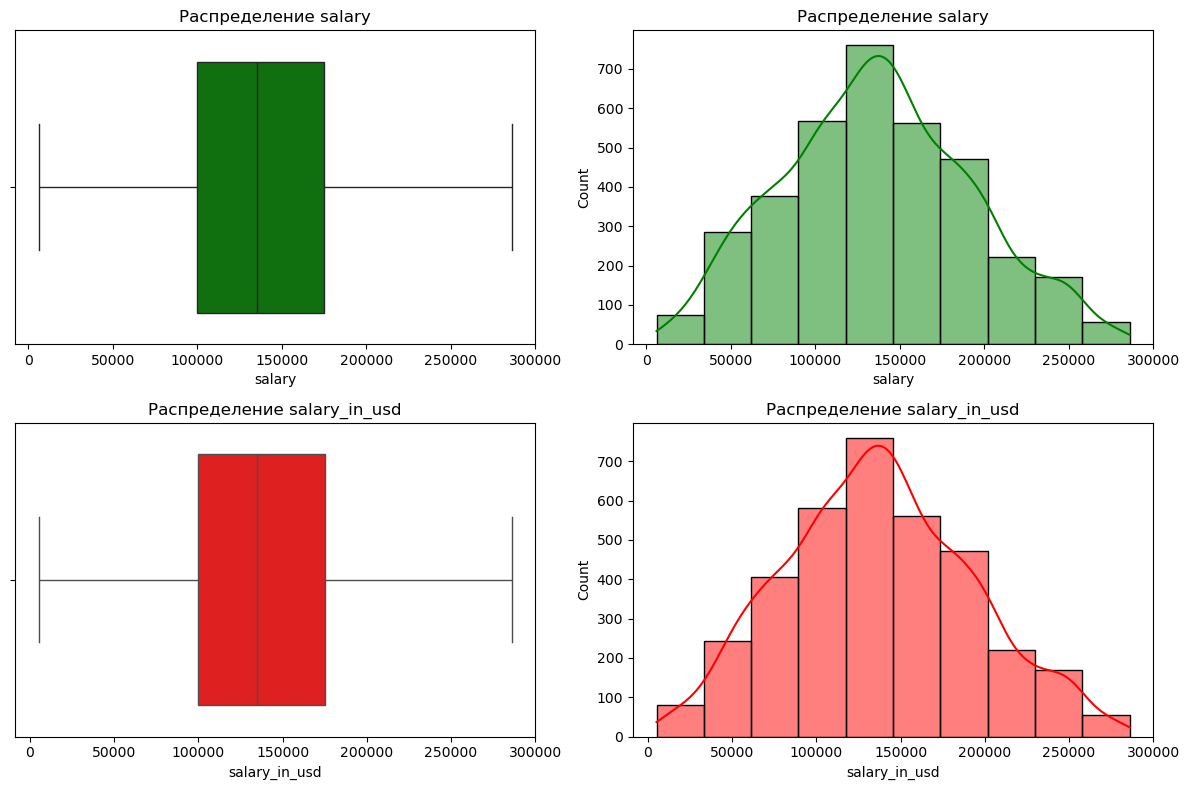

In [6]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.boxplot(x=df['salary'], color='green')
plt.title('Распределение salary')

plt.subplot(2, 2, 2)
sns.histplot(df['salary'], bins=10, kde=True, color='green')
plt.title('Распределение salary')

plt.subplot(2, 2, 3)
sns.boxplot(x=df['salary_in_usd'], color='red')
plt.title('Распределение salary_in_usd')

plt.subplot(2, 2, 4)
sns.histplot(df['salary_in_usd'], bins=10, kde=True, color='red')
plt.title('Распределение salary_in_usd')

plt.tight_layout()
plt.show()


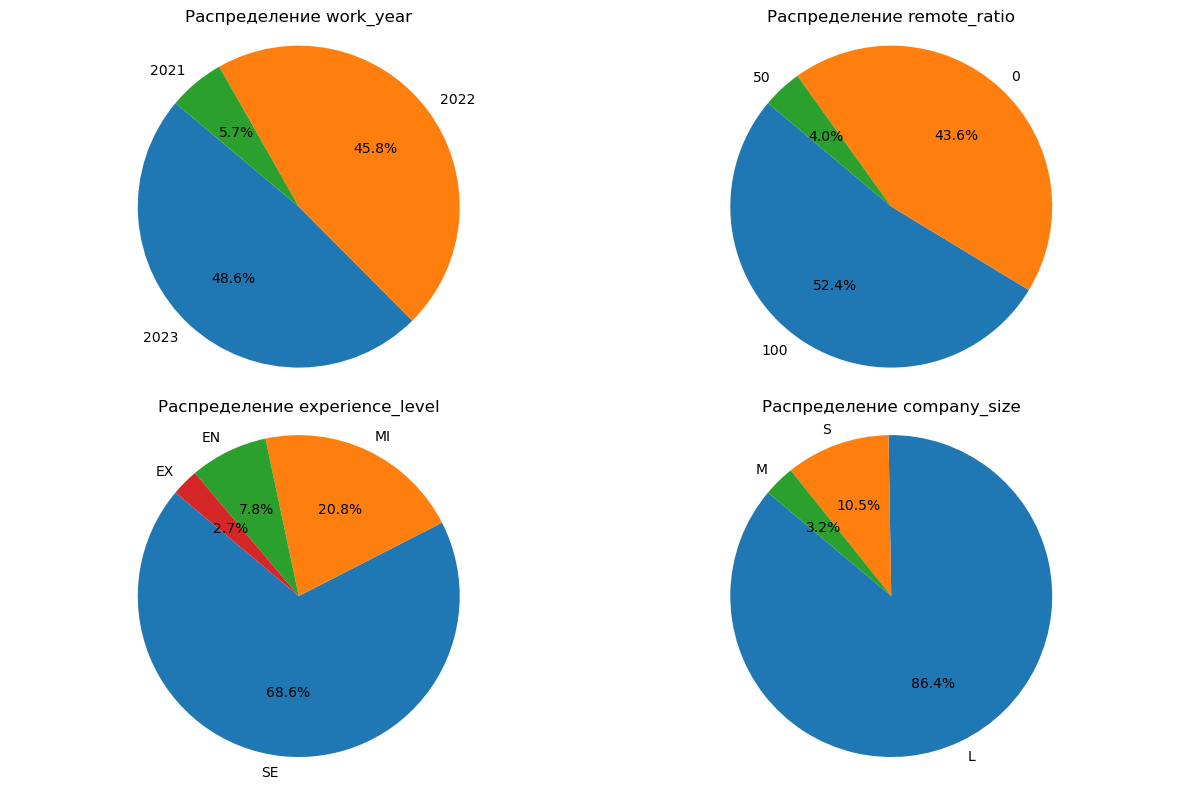

In [7]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.pie(df['work_year'].value_counts(), labels=df['work_year'].unique(), 
autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Распределение work_year')

plt.subplot(2, 2, 2)
plt.pie(df['remote_ratio'].value_counts(), labels=df['remote_ratio'].unique(), 
autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Распределение remote_ratio')

plt.subplot(2, 2, 3)
plt.pie(df['experience_level'].value_counts(), labels=df['experience_level'].unique(), 
autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Распределение experience_level')

plt.subplot(2, 2, 4)
plt.pie(df['company_size'].value_counts(), labels=df['company_size'].unique(), 
autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Распределение company_size')

plt.tight_layout()
plt.show()


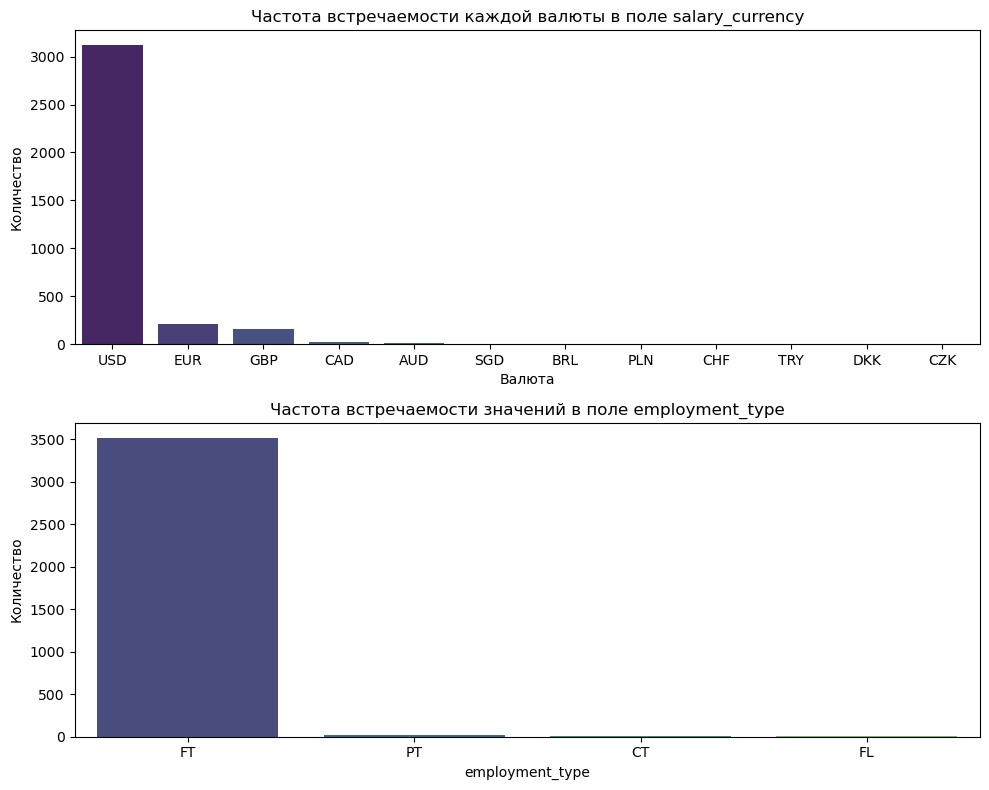

In [8]:
warnings.filterwarnings("ignore")

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.countplot(data=df, x='salary_currency', palette='viridis', order=df['salary_currency'].value_counts().index)
plt.title('Частота встречаемости каждой валюты в поле salary_currency')
plt.xlabel('Валюта')
plt.ylabel('Количество')

plt.subplot(2, 1, 2)
sns.countplot(data=df, x='employment_type', palette='viridis', order=df['employment_type'].value_counts().index)
plt.title('Частота встречаемости значений в поле employment_type')
plt.ylabel('Количество')

plt.tight_layout()
plt.show()


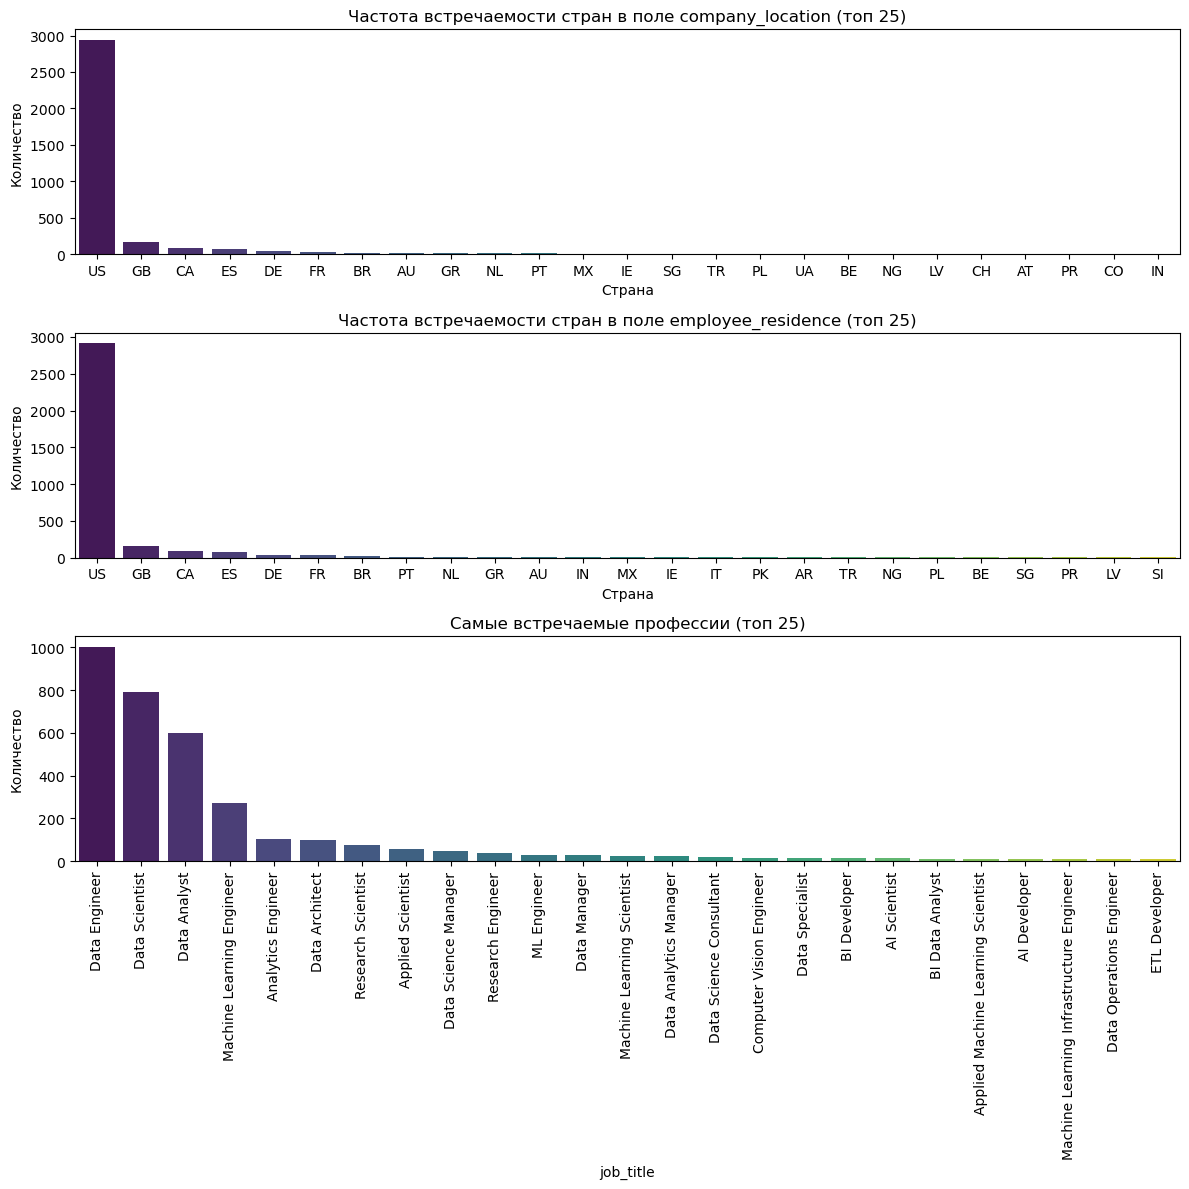

In [9]:
warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
top_25_countries = df['company_location'].value_counts().nlargest(25).index
sns.countplot(data=df[df['company_location'].isin(top_25_countries)], 
              x='company_location', 
              palette='viridis', 
              order=top_25_countries)

plt.title('Частота встречаемости стран в поле company_location (топ 25)')
plt.xlabel('Страна')
plt.ylabel('Количество')

plt.subplot(3, 1, 2)
top_25_countries = df['employee_residence'].value_counts().nlargest(25).index
sns.countplot(data=df[df['employee_residence'].isin(top_25_countries)], 
              x='employee_residence', 
              palette='viridis', 
              order=top_25_countries)
plt.title('Частота встречаемости стран в поле employee_residence (топ 25)')
plt.xlabel('Страна')
plt.ylabel('Количество')

plt.subplot(3, 1, 3)
top_25_job = df['job_title'].value_counts().nlargest(25).index
sns.countplot(data=df[df['job_title'].isin(top_25_job)], 
              x='job_title', 
              palette='viridis', 
              order=top_25_job)
plt.title('Самые встречаемые профессии (топ 25)')
plt.ylabel('Количество')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

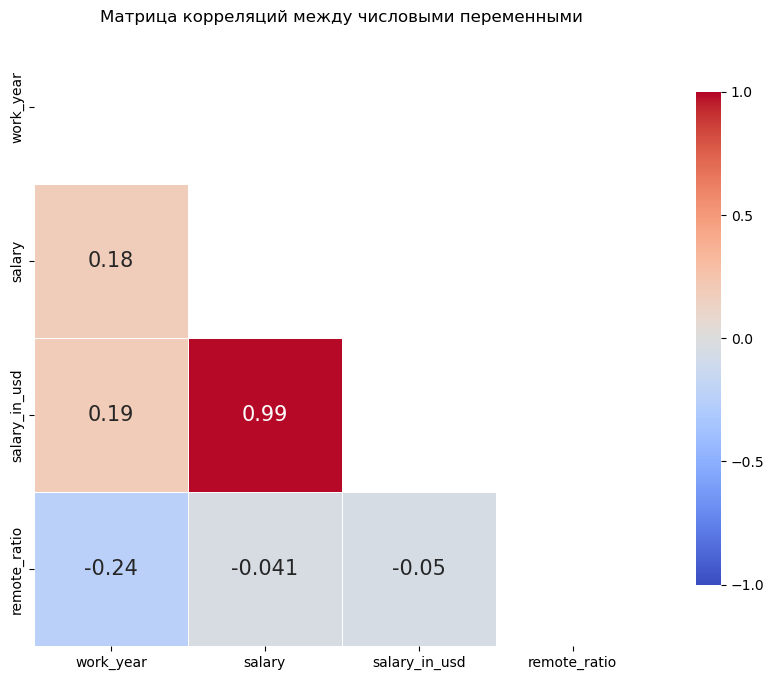

In [10]:
df_numeric = df.select_dtypes(include=['number']).copy()

correlation_matrix = df_numeric.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0, 
            square=True, linewidths=.5, annot_kws={"size": 15}, 
            cbar_kws={"shrink": 0.8, "orientation": "vertical", "ticks": [-1, -0.5, 0, 0.5, 1]})
plt.title('Матрица корреляций между числовыми переменными')
plt.show()


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Трансформация признаков </h1> 

* Удалим поле salary_in_usd из дата-фрейма из-за сильной корреляции с таргетом salary

* Преобразуем категориальные переменные

In [11]:
df = df.drop(columns=['salary_in_usd'])

# experience_level
df_gender_dummies = pd.get_dummies(df['experience_level'], prefix='experience_level')
df = pd.concat([df, df_gender_dummies], axis=1)
df = df.drop(columns=['experience_level'])

# employment_type
df_BMI_Category = pd.get_dummies(df['employment_type'], prefix='employment_type')
df = pd.concat([df, df_BMI_Category], axis=1)
df = df.drop(columns=['employment_type'])

# salary_currency
df_Sleep_Disorder = pd.get_dummies(df['salary_currency'], prefix='salary_currency')
df = pd.concat([df, df_Sleep_Disorder], axis=1)
df = df.drop(columns=['salary_currency'])

# employee_residence
df_Sleep_Disorder = pd.get_dummies(df['employee_residence'], prefix='employee_residence')
df = pd.concat([df, df_Sleep_Disorder], axis=1)
df = df.drop(columns=['employee_residence'])

# company_location
df_Sleep_Disorder = pd.get_dummies(df['company_location'], prefix='company_location')
df = pd.concat([df, df_Sleep_Disorder], axis=1)
df = df.drop(columns=['company_location'])

# company_size
df_Sleep_Disorder = pd.get_dummies(df['company_size'], prefix='company_size')
df = pd.concat([df, df_Sleep_Disorder], axis=1)
df = df.drop(columns=['company_size'])

# job_title
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['job_title'])
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
df = pd.concat([df, df_tfidf], axis=1)
df = df.drop(columns=['job_title'])

df = df.dropna()

df['work_year'] = df['work_year'].astype(int)
df['remote_ratio'] = df['remote_ratio'].astype(int)
df['salary'] = df['salary'].astype(int)

df

,work_year,salary,remote_ratio,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,employment_type_FT,...,researcher,science,scientist,software,specialist,staff,strategist,technician,vehicle,vision
0,2023,80000,100,False,False,False,True,False,False,True,...,0.0,0.000000,0.316926,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023,30000,100,False,False,True,False,True,False,False,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023,25500,100,False,False,True,False,True,False,False,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,175000,100,False,False,False,True,False,False,True,...,0.0,0.000000,0.877614,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023,120000,100,False,False,False,True,False,False,True,...,0.0,0.000000,0.877614,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3541,2021,130000,100,False,True,False,False,False,False,True,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3542,2021,110000,100,False,False,True,False,False,False,True,...,0.0,0.447448,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3543,2021,110000,100,False,False,True,False,False,False,True,...,0.0,0.000000,0.877614,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3544,2021,60000,50,True,False,False,False,False,False,True,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Нормализация данных</h1> 

In [24]:
X = df.drop(columns=['salary'])
y = df['salary']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Кластеризация данных </h1> 

### <h1 id="aa" style="color:white;background:#01BAEF;padding:8px;border-radius:8px;font-family:newtimeroman;"> K-Means </h1> 

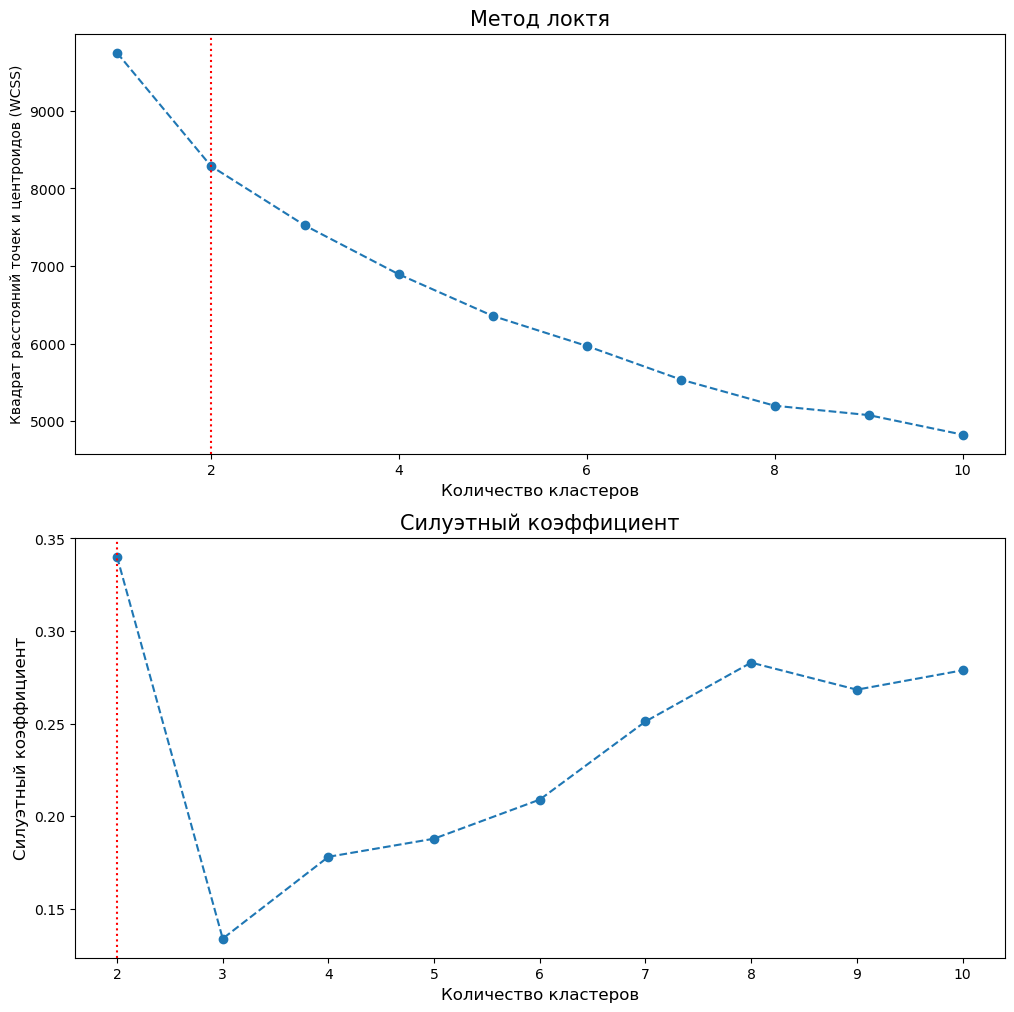

In [25]:
plt.figure(figsize=(12, 12))

# Метод локтя
wcss = []  
for i in range(1, 11):
    # k-means++ — улучшенная версия случайной инициализации центроидов.
    # max_iter=300 - максимальное количество итераций, которое алгоритм K-Means будет выполнять, пытаясь минимизировать WCSS
    # n_init=10 - количество раз, которое алгоритм будет запускаться с различными начальными центроидами. 
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.subplot(2, 1, 1)
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', linewidth=1.5)
plt.axvline(x=2, linestyle=':', color='r') 
plt.title('Метод локтя', fontsize=15)
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('Квадрат расстояний точек и центроидов (WCSS)')

# Метод силуэта
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.subplot(2, 1, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--', linewidth=1.5)
plt.axvline(x=2, linestyle=':', color='r') 
plt.title('Силуэтный коэффициент', fontsize=15)
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('Силуэтный коэффициент', fontsize=12)

plt.show()


* Метод локтя показывает, что существенный перегиб кривой значений WCSS от количества кластеров происходит при 2-ух кластерах.
* Метод силуэта показывает, что наибольший коэффициент (чем ближе к +1, тем лучше проведна кластеризация) получается при разбиении данных на 2 кластера.

In [26]:
# Обучаем модель KMeans для 2-ух кластеров
optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Добавляем метки кластеров (0 или 1) в признаки как
X = pd.DataFrame(X_scaled, columns=X.columns)
X['clusters_kmeans'] = clusters

# Размеры кластеров
print(f"Распределение по выделенным кластерам: \n{X['clusters_kmeans'].value_counts().sort_index()}")

X


Распределение по выделенным кластерам: 
clusters_kmeans
0     553
1    2865
Name: count, dtype: int64


,work_year,remote_ratio,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,...,science,scientist,software,specialist,staff,strategist,technician,vehicle,vision,clusters_kmeans
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.000000,0.361123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3413,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3414,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.496498,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3415,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3416,0.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


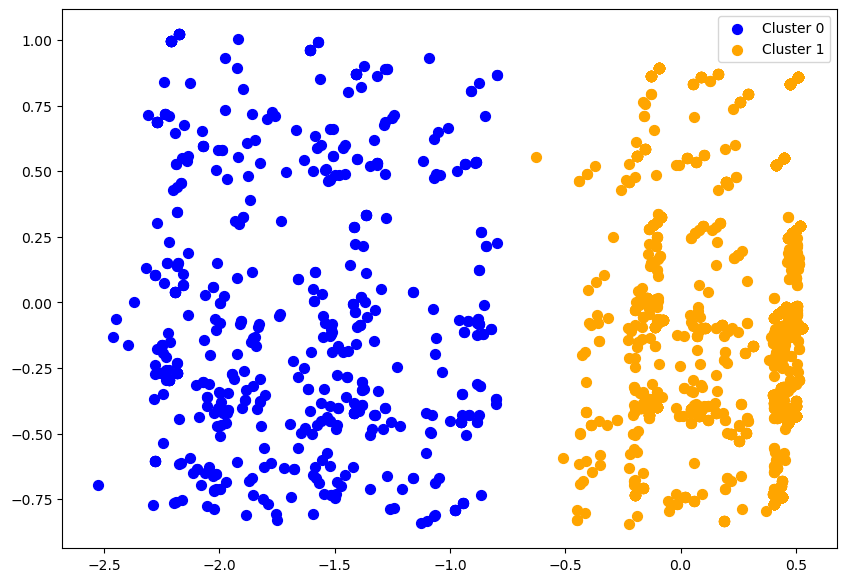

In [27]:
# Выделяем 2 главных признака для графика
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca_df['cluster'] = clusters

plt.figure(figsize=(10, 7))
colors = ['blue', 'orange']
for i in range(optimal_clusters):
    cluster_data = X_pca_df[X_pca_df['cluster'] == i]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], 
                s=50, c=colors[i], label=f'Cluster {i}')

plt.legend()
plt.show()


### <h1 id="aa" style="color:white;background:#01BAEF;padding:8px;border-radius:8px;font-family:newtimeroman;"> DBSCAN </h1> 

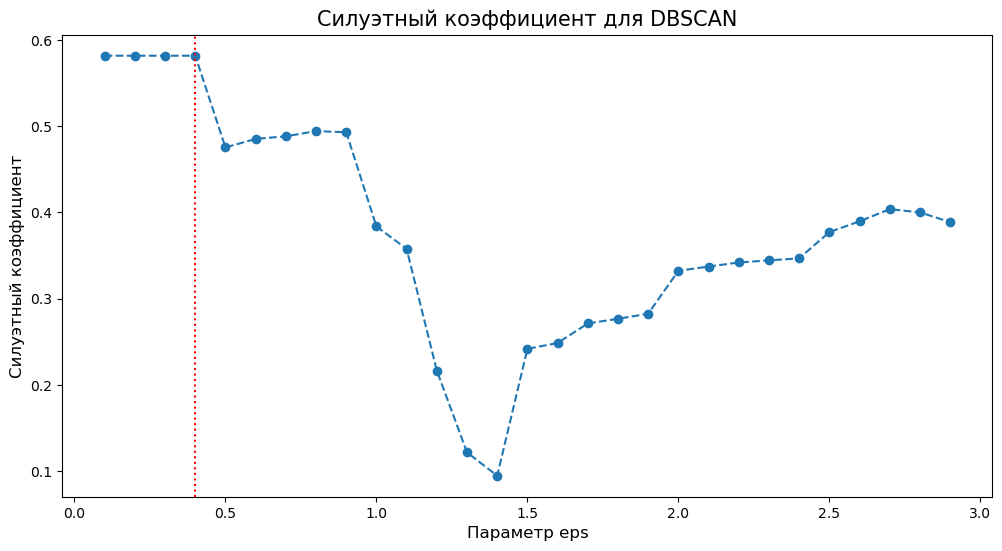

In [20]:
# Силуэтный коэффициент для различных параметров eps - максимальное расстояние между двумя точками, чтобы они считались соседями
eps_values = np.arange(0.1, 3, 0.1)
silhouette_scores = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    clusters = dbscan.fit_predict(X_scaled)
    if len(set(clusters)) > 1:
        score = silhouette_score(X_scaled, clusters)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # Если один кластер, силуэтный коэффициент некорректен

plt.figure(figsize=(12, 6))
plt.plot(eps_values, silhouette_scores, marker='o', linestyle='--', linewidth=1.5)
plt.axvline(x=0.4, linestyle=':', color='r') 
plt.title('Силуэтный коэффициент для DBSCAN', fontsize=15)
plt.xlabel('Параметр eps', fontsize=12)
plt.ylabel('Силуэтный коэффициент', fontsize=12)
plt.show()


In [21]:
# Обучаем модель DBSCAN с оптимальным значением eps
optimal_eps = 0.4
dbscan = DBSCAN(eps=optimal_eps, min_samples=100)
clusters = dbscan.fit_predict(X_scaled)

# Добавляем метки кластеров в данные
df_dbscan = pd.DataFrame(X_scaled, columns=[f'Feature_{i+1}' for i in range(X_scaled.shape[1])])
df_dbscan['clusters_dbscan'] = clusters

# Размеры кластеров
print(f"Распределение по выделенным кластерам: \n{df_dbscan['clusters_dbscan'].value_counts().sort_index()}")

df_dbscan

Распределение по выделенным кластерам: 
clusters_dbscan
-1    2446
 0     145
 1     219
 2     105
 3     114
 4     123
 5     127
 6     139
Name: count, dtype: int64


,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_214,Feature_215,Feature_216,Feature_217,Feature_218,Feature_219,Feature_220,Feature_221,Feature_222,clusters_dbscan
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.000000,0.361123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3413,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3414,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.496498,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3415,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3416,0.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


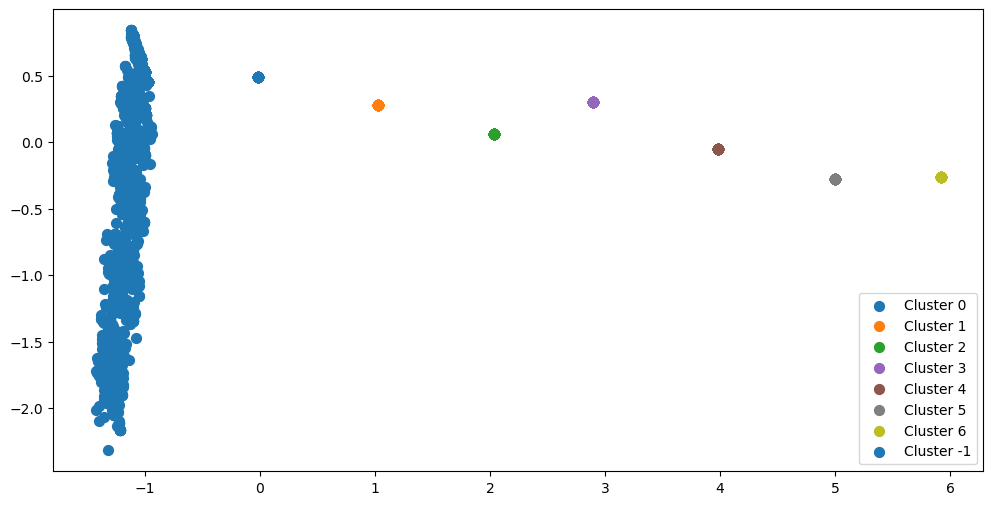

In [22]:
# Выделяем 2 главных признака для графика
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_dbscan)
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca_df['cluster'] = clusters

plt.figure(figsize=(12, 6))
unique_clusters = set(clusters)
colors = plt.cm.get_cmap('tab10', len(unique_clusters))

for cluster in unique_clusters:
    cluster_data = X_pca_df[X_pca_df['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], 
                s=50, c=np.array([colors(cluster)]), label=f'Cluster {cluster}')

plt.legend()
plt.show()


* Результат кластеризации методом DBSCAN неудовлетворительный, его добавлять к признакам для обучения моделей не нужно.

## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Разделение данных на выборки</h1> 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер X_train: {X_train.shape}")
print(f"Размер X_test: {X_test.shape}")
print(f"Размер y_train: {y_train.shape}")
print(f"Размер y_test: {y_test.shape}")


Размер X_train: (2734, 223)
Размер X_test: (684, 223)
Размер y_train: (2734,)
Размер y_test: (684,)


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Отбор признаков с помощью PCA</h1> 

In [32]:
pca = PCA(n_components=50) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Размер X_train после PCA: {X_train_pca.shape}")
print(f"Размер X_test после PCA: {X_test_pca.shape}")
print(f"Размер y_train: {y_train.shape}")
print(f"Размер y_test: {y_test.shape}")

Размер X_train после PCA: (2734, 50)
Размер X_test после PCA: (684, 50)
Размер y_train: (2734,)
Размер y_test: (684,)


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Модели линейной регрессии </h1> 

In [59]:
# Обучение модели линейной регрессии на всех признаках
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)


# Обучение модели линейной регрессии на данных после PCA
lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)

y_pred_train_pca = lr_pca.predict(X_train_pca)
y_pred_test_pca = lr_pca.predict(X_test_pca)

mae_train_pca = mean_absolute_error(y_train, y_pred_train_pca)
rmse_train_pca = np.sqrt(mean_squared_error(y_train, y_pred_train_pca))
r2_train_pca = r2_score(y_train, y_pred_train_pca)

mae_test_pca = mean_absolute_error(y_test, y_pred_test_pca)
rmse_test_pca = np.sqrt(mean_squared_error(y_test, y_pred_test_pca))
r2_test_pca = r2_score(y_test, y_pred_test_pca)

print("Оценка модели, обученной на всех признаках:")
print(f"MAE (train): {mae_train:.4f}")
print(f"RMSE (train): {rmse_train:.4f}")
print(f"R^2 (train): {r2_train:.4f}")
print(f"MAE (test): {mae_test:.4f}")
print(f"RMSE (test): {rmse_test:.4f}")
print(f"R^2 (test): {r2_test:.4f}")

print("\nОценка модели на признаках, отобранных с помощью PCA:")
print(f"MAE (train): {mae_train_pca:.4f}")
print(f"RMSE (train): {rmse_train_pca:.4f}")
print(f"R^2 (train): {r2_train_pca:.4f}")
print(f"MAE (test): {mae_test_pca:.4f}")
print(f"RMSE (test): {rmse_test_pca:.4f}")
print(f"R^2 (test): {r2_test_pca:.4f}")

results = {
    'Model': ['Linear Regression (All Features)', 'Linear Regression (PCA)'],
    'MAE (Train)': [mae_train, mae_train_pca],
    'RMSE (Train)': [rmse_train, rmse_train_pca],
    'R^2 (Train)': [r2_train, r2_train_pca],
    'MAE (Test)': [mae_test, mae_test_pca],
    'RMSE (Test)': [rmse_test, rmse_test_pca],
    'R^2 (Test)': [r2_test, r2_test_pca]
}

score_df = pd.DataFrame(results)

Оценка модели, обученной на всех признаках:
MAE (train): 34627.4448
RMSE (train): 43890.1245
R^2 (train): 0.3705
MAE (test): 2668645761227150.5000
RMSE (test): 37665668305138288.0000
R^2 (test): -442979429666048624820224.0000

Оценка модели на признаках, отобранных с помощью PCA:
MAE (train): 35435.6448
RMSE (train): 44441.4951
R^2 (train): 0.3546
MAE (test): 37128.9277
RMSE (test): 46323.9405
R^2 (test): 0.3300


* Как мы видим более лучше себя показала модель на тесте с признаками, отобранными с помощью PCA. 
* В модели обученной на всех признаках метрики ошибок лучше на тренировочной выборке, но очень большие на тесте - модель не научились обощать информацию.
* Для признаков после PCA мультиколлинеарность не требуется анализа, так как компоненты PCA ортогональны друг другу

### <h1 id="aa" style="color:white;background:#01BAEF;padding:8px;border-radius:8px;font-family:newtimeroman;"> Анализ значимости признаков </h1> 

In [37]:
X_train_with_const = add_constant(X_train)
vif = pd.DataFrame()
vif['Feature'] = X_train_with_const.columns
vif['VIF'] = [variance_inflation_factor(X_train_with_const.values, i) for i in range(X_train_with_const.shape[1])]
print("\nАнализ мультиколлинеарности для исходных признаков:")
print(vif)



Анализ мультиколлинеарности для исходных признаков:
                 Feature           VIF
0                  const  0.000000e+00
1              work_year  1.229784e+00
2           remote_ratio  1.144080e+00
3    experience_level_EN  2.506947e+05
4    experience_level_EX  6.808633e+04
..                   ...           ...
219           strategist  1.931927e+00
220           technician           inf
221              vehicle           inf
222               vision  7.437488e+09
223      clusters_kmeans  1.859038e+02

[224 rows x 2 columns]


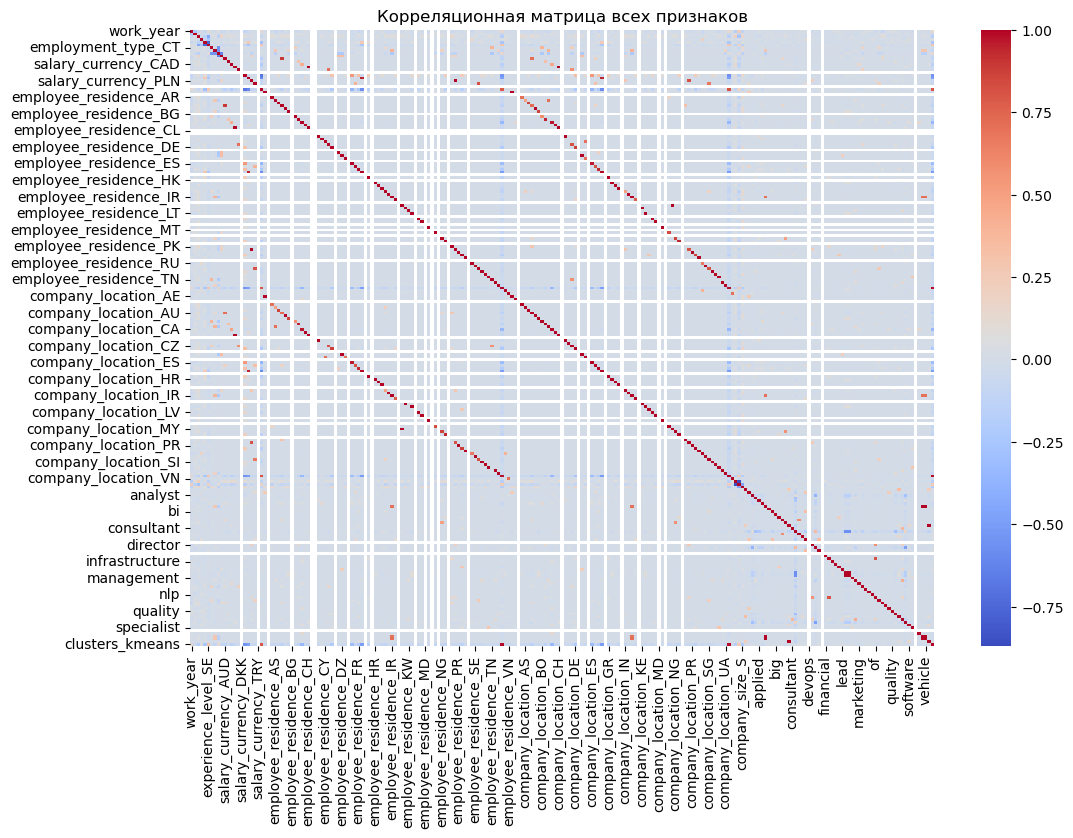

In [38]:
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=False, cmap='coolwarm')
plt.title("Корреляционная матрица всех признаков")
plt.show()


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Модели деревьев решений</h1> 

In [60]:
# Обучение модели дерева решений на всех признаках
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_train_dt = dt.predict(X_train)
y_pred_test_dt = dt.predict(X_test)

mae_train_dt = mean_absolute_error(y_train, y_pred_train_dt)
rmse_train_dt = np.sqrt(mean_squared_error(y_train, y_pred_train_dt))
r2_train_dt = r2_score(y_train, y_pred_train_dt)

mae_test_dt = mean_absolute_error(y_test, y_pred_test_dt)
rmse_test_dt = np.sqrt(mean_squared_error(y_test, y_pred_test_dt))
r2_test_dt = r2_score(y_test, y_pred_test_dt)

print("Оценка модели дерева решений, обученной на всех признаках:")
print(f"MAE (train): {mae_train_dt:.4f}")
print(f"RMSE (train): {rmse_train_dt:.4f}")
print(f"R^2 (train): {r2_train_dt:.4f}")
print(f"MAE (test): {mae_test_dt:.4f}")
print(f"RMSE (test): {rmse_test_dt:.4f}")
print(f"R^2 (test): {r2_test_dt:.4f}")


# Обучение модели дерева решений на данных после PCA
dt_pca = DecisionTreeRegressor(random_state=42)
dt_pca.fit(X_train_pca, y_train)

y_pred_train_dt_pca = dt_pca.predict(X_train_pca)
y_pred_test_dt_pca = dt_pca.predict(X_test_pca)

mae_train_dt_pca = mean_absolute_error(y_train, y_pred_train_dt_pca)
rmse_train_dt_pca = np.sqrt(mean_squared_error(y_train, y_pred_train_dt_pca))
r2_train_dt_pca = r2_score(y_train, y_pred_train_dt_pca)

mae_test_dt_pca = mean_absolute_error(y_test, y_pred_test_dt_pca)
rmse_test_dt_pca = np.sqrt(mean_squared_error(y_test, y_pred_test_dt_pca))
r2_test_dt_pca = r2_score(y_test, y_pred_test_dt_pca)

print("\nОценка модели дерева решений на признаках, отобранных с помощью PCA:")
print(f"MAE (train): {mae_train_dt_pca:.4f}")
print(f"RMSE (train): {rmse_train_dt_pca:.4f}")
print(f"R^2 (train): {r2_train_dt_pca:.4f}")
print(f"MAE (test): {mae_test_dt_pca:.4f}")
print(f"RMSE (test): {rmse_test_dt_pca:.4f}")
print(f"R^2 (test): {r2_test_dt_pca:.4f}")

results = {
    'Model': ['Decision Tree (All Features)', 'Decision Tree (PCA)'],
    'MAE (Train)': [mae_train_dt, mae_train_dt_pca],
    'RMSE (Train)': [rmse_train_dt, rmse_train_dt_pca],
    'R^2 (Train)': [r2_train_dt, r2_train_dt_pca],
    'MAE (Test)': [mae_test_dt, mae_test_dt_pca],
    'RMSE (Test)': [rmse_test_dt, rmse_test_dt_pca],
    'R^2 (Test)': [r2_test_dt, r2_test_dt_pca]
}
new_df = pd.DataFrame(results)
score_df = pd.concat([score_df, new_df], ignore_index=True)


Оценка модели дерева решений, обученной на всех признаках:
MAE (train): 28225.5944
RMSE (train): 38912.3856
R^2 (train): 0.5052
MAE (test): 39679.5944
RMSE (test): 49951.4484
R^2 (test): 0.2209

Оценка модели дерева решений на признаках, отобранных с помощью PCA:
MAE (train): 28225.5944
RMSE (train): 38912.3856
R^2 (train): 0.5052
MAE (test): 39287.7967
RMSE (test): 49221.7155
R^2 (test): 0.2435


* Чуть более лучший результат у модели обученной на признаках, отобранных с помощью PCA.


### <h1 id="aa" style="color:white;background:#01BAEF;padding:8px;border-radius:8px;font-family:newtimeroman;"> Визуализация </h1> 

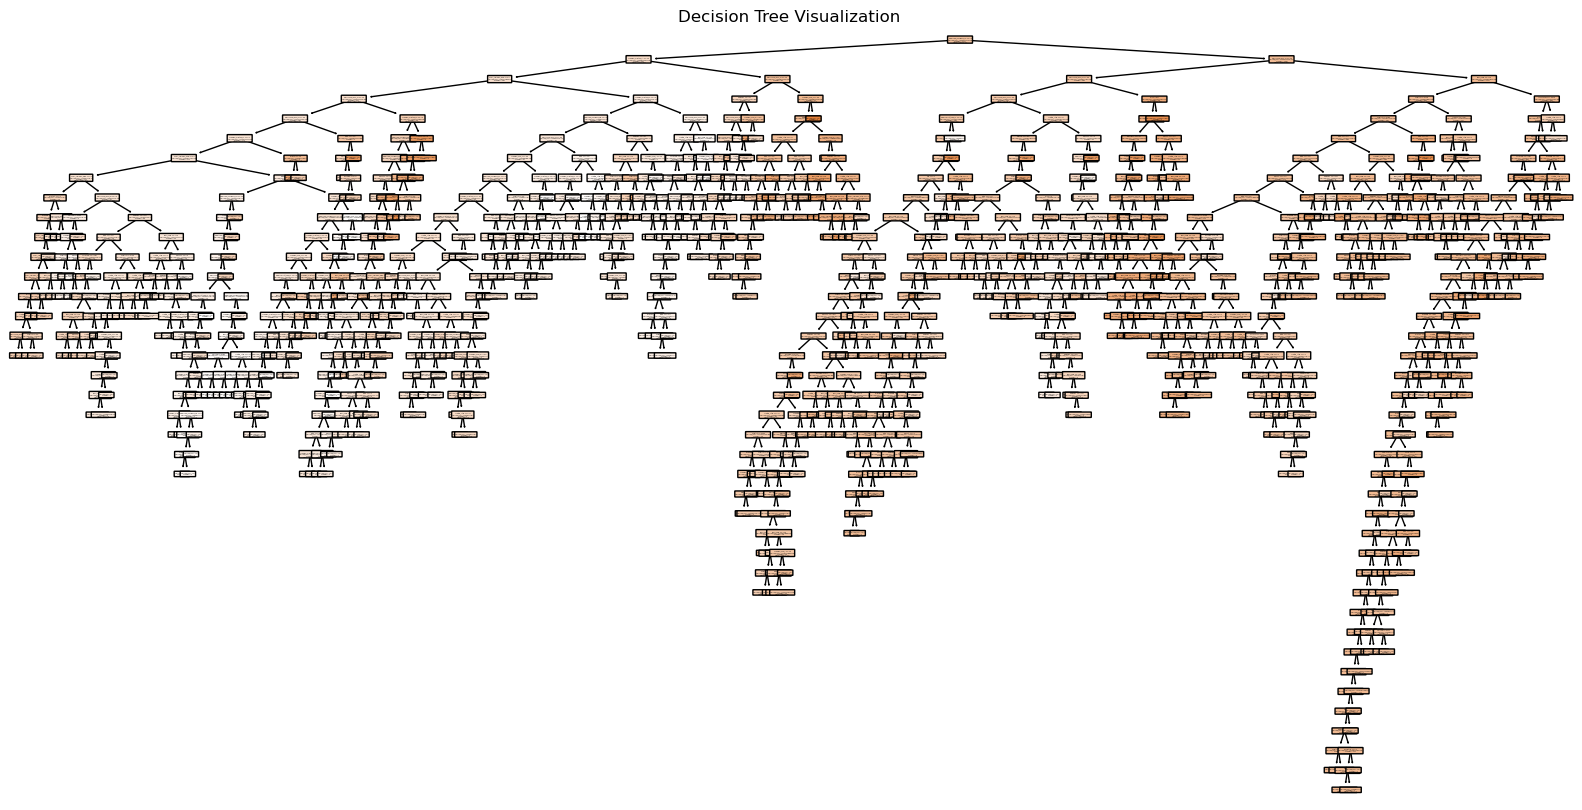

In [45]:
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=X_train.columns, rounded=True, class_names=["Class 0", "Class 1"]) 
plt.title("Decision Tree Visualization")
plt.show()


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Модели Random Forest </h1> 

In [62]:
# Обучение модели случайного леса на всех признаках
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)

mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
r2_train_rf = r2_score(y_train, y_pred_train_rf)

mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
r2_test_rf = r2_score(y_test, y_pred_test_rf)

print("Оценка модели случайного леса, обученной на всех признаках:")
print(f"MAE (train): {mae_train_rf:.4f}")
print(f"RMSE (train): {rmse_train_rf:.4f}")
print(f"R^2 (train): {r2_train_rf:.4f}")
print(f"MAE (test): {mae_test_rf:.4f}")
print(f"RMSE (test): {rmse_test_rf:.4f}")
print(f"R^2 (test): {r2_test_rf:.4f}")


# Обучение модели случайного леса на данных после PCA
rf_pca = RandomForestRegressor(random_state=42)
rf_pca.fit(X_train_pca, y_train)

y_pred_train_rf_pca = rf_pca.predict(X_train_pca)
y_pred_test_rf_pca = rf_pca.predict(X_test_pca)

mae_train_rf_pca = mean_absolute_error(y_train, y_pred_train_rf_pca)
rmse_train_rf_pca = np.sqrt(mean_squared_error(y_train, y_pred_train_rf_pca))
r2_train_rf_pca = r2_score(y_train, y_pred_train_rf_pca)

mae_test_rf_pca = mean_absolute_error(y_test, y_pred_test_rf_pca)
rmse_test_rf_pca = np.sqrt(mean_squared_error(y_test, y_pred_test_rf_pca))
r2_test_rf_pca = r2_score(y_test, y_pred_test_rf_pca)

print("\nОценка модели случайного леса на признаках, отобранных с помощью PCA:")
print(f"MAE (train): {mae_train_rf_pca:.4f}")
print(f"RMSE (train): {rmse_train_rf_pca:.4f}")
print(f"R^2 (train): {r2_train_rf_pca:.4f}")
print(f"MAE (test): {mae_test_rf_pca:.4f}")
print(f"RMSE (test): {rmse_test_rf_pca:.4f}")
print(f"R^2 (test): {r2_test_rf_pca:.4f}")

results = {
    'Model': ['Random Forest (All Features)', 'Random Forest (PCA)'],
    'MAE (Train)': [mae_train_rf, mae_train_rf_pca],
    'RMSE (Train)': [rmse_train_rf, rmse_train_rf_pca],
    'R^2 (Train)': [r2_train_rf, r2_train_rf_pca],
    'MAE (Test)': [mae_test_rf, mae_test_rf_pca],
    'RMSE (Test)': [rmse_test_rf, rmse_test_rf_pca],
    'R^2 (Test)': [r2_test_rf, r2_test_rf_pca]
}
new_df = pd.DataFrame(results)
score_df = pd.concat([score_df, new_df], ignore_index=True)

Оценка модели случайного леса, обученной на всех признаках:
MAE (train): 30343.7355
RMSE (train): 39549.4680
R^2 (train): 0.4889
MAE (test): 37320.4984
RMSE (test): 46831.7489
R^2 (test): 0.3152

Оценка модели случайного леса на признаках, отобранных с помощью PCA:
MAE (train): 30307.4160
RMSE (train): 39518.1622
R^2 (train): 0.4897
MAE (test): 37337.6431
RMSE (test): 46814.8423
R^2 (test): 0.3157


* Чуть более лучший результат у модели обученной на признаках, отобранных с помощью PCA.

### <h1 id="aa" style="color:white;background:#01BAEF;padding:8px;border-radius:8px;font-family:newtimeroman;"> Отбор наиболее значимых признаков </h1> 

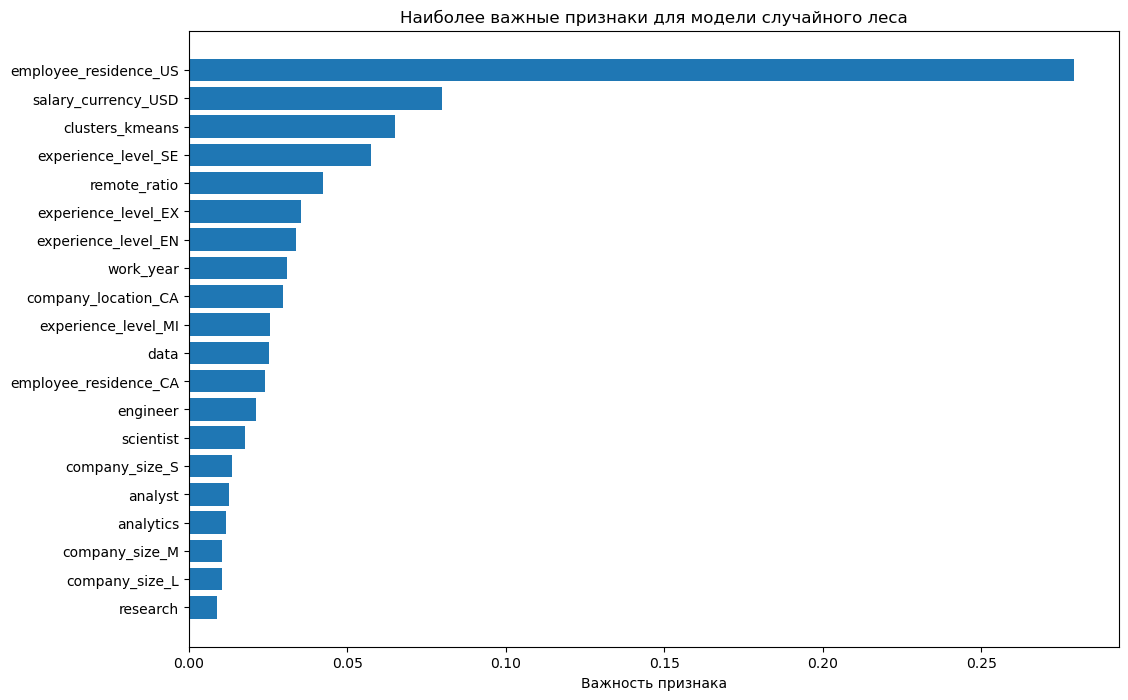

In [52]:
# Обучение модели случайного леса на всех признаках
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Получение важности признаков
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 20
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_feature_names = X_train.columns[top_indices]

plt.figure(figsize=(12, 8))
plt.title("Наиболее важные признаки для модели случайного леса")
plt.barh(range(top_n), top_importances, align="center")
plt.yticks(range(top_n), top_feature_names)
plt.xlabel("Важность признака")
plt.gca().invert_yaxis()  # Инвертировать ось y, чтобы на верхней позиции был наиболее важный признак
plt.show()


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Модели Boosting</h1> 

In [64]:
# Обучение модели градиентного бустинга на всех признаках
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred_train_gbr = gbr.predict(X_train)
y_pred_test_gbr = gbr.predict(X_test)

mae_train_gbr = mean_absolute_error(y_train, y_pred_train_gbr)
rmse_train_gbr = np.sqrt(mean_squared_error(y_train, y_pred_train_gbr))
r2_train_gbr = r2_score(y_train, y_pred_train_gbr)

mae_test_gbr = mean_absolute_error(y_test, y_pred_test_gbr)
rmse_test_gbr = np.sqrt(mean_squared_error(y_test, y_pred_test_gbr))
r2_test_gbr = r2_score(y_test, y_pred_test_gbr)

print("Оценка модели градиентного бустинга, обученной на всех признаках:")
print(f"MAE (train): {mae_train_gbr:.4f}")
print(f"RMSE (train): {rmse_train_gbr:.4f}")
print(f"R^2 (train): {r2_train_gbr:.4f}")
print(f"MAE (test): {mae_test_gbr:.4f}")
print(f"RMSE (test): {rmse_test_gbr:.4f}")
print(f"R^2 (test): {r2_test_gbr:.4f}")


# Обучение модели градиентного бустинга на данных после PCA
gbr_pca = GradientBoostingRegressor(random_state=42)
gbr_pca.fit(X_train_pca, y_train)

y_pred_train_gbr_pca = gbr_pca.predict(X_train_pca)
y_pred_test_gbr_pca = gbr_pca.predict(X_test_pca)

mae_train_gbr_pca = mean_absolute_error(y_train, y_pred_train_gbr_pca)
rmse_train_gbr_pca = np.sqrt(mean_squared_error(y_train, y_pred_train_gbr_pca))
r2_train_gbr_pca = r2_score(y_train, y_pred_train_gbr_pca)

mae_test_gbr_pca = mean_absolute_error(y_test, y_pred_test_gbr_pca)
rmse_test_gbr_pca = np.sqrt(mean_squared_error(y_test, y_pred_test_gbr_pca))
r2_test_gbr_pca = r2_score(y_test, y_pred_test_gbr_pca)

print("\nОценка модели градиентного бустинга на признаках, отобранных с помощью PCA:")
print(f"MAE (train): {mae_train_gbr_pca:.4f}")
print(f"RMSE (train): {rmse_train_gbr_pca:.4f}")
print(f"R^2 (train): {r2_train_gbr_pca:.4f}")
print(f"MAE (test): {mae_test_gbr_pca:.4f}")
print(f"RMSE (test): {rmse_test_gbr_pca:.4f}")
print(f"R^2 (test): {r2_test_gbr_pca:.4f}")

results = {
    'Model': ['Boosting (All Features)', 'Boosting (PCA)'],
    'MAE (Train)': [mae_train_gbr, mae_train_gbr_pca],
    'RMSE (Train)': [rmse_train_gbr, rmse_train_gbr_pca],
    'R^2 (Train)': [r2_train_gbr, r2_train_gbr_pca],
    'MAE (Test)': [mae_test_gbr, mae_test_gbr_pca],
    'RMSE (Test)': [rmse_test_gbr, rmse_test_gbr_pca],
    'R^2 (Test)': [r2_test_gbr, r2_test_gbr_pca]
}
new_df = pd.DataFrame(results)
score_df = pd.concat([score_df, new_df], ignore_index=True)


Оценка модели градиентного бустинга, обученной на всех признаках:
MAE (train): 34213.8574
RMSE (train): 43125.3878
R^2 (train): 0.3923
MAE (test): 36876.9486
RMSE (test): 46155.9659
R^2 (test): 0.3348

Оценка модели градиентного бустинга на признаках, отобранных с помощью PCA:
MAE (train): 32562.5994
RMSE (train): 41380.9213
R^2 (train): 0.4405
MAE (test): 36976.9084
RMSE (test): 46459.1251
R^2 (test): 0.3260


* Здесь чуть более лучший результат у модели обученной на всех признаках.

### <h1 id="aa" style="color:white;background:#01BAEF;padding:8px;border-radius:8px;font-family:newtimeroman;"> Отбор наиболее значимых признаков </h1> 

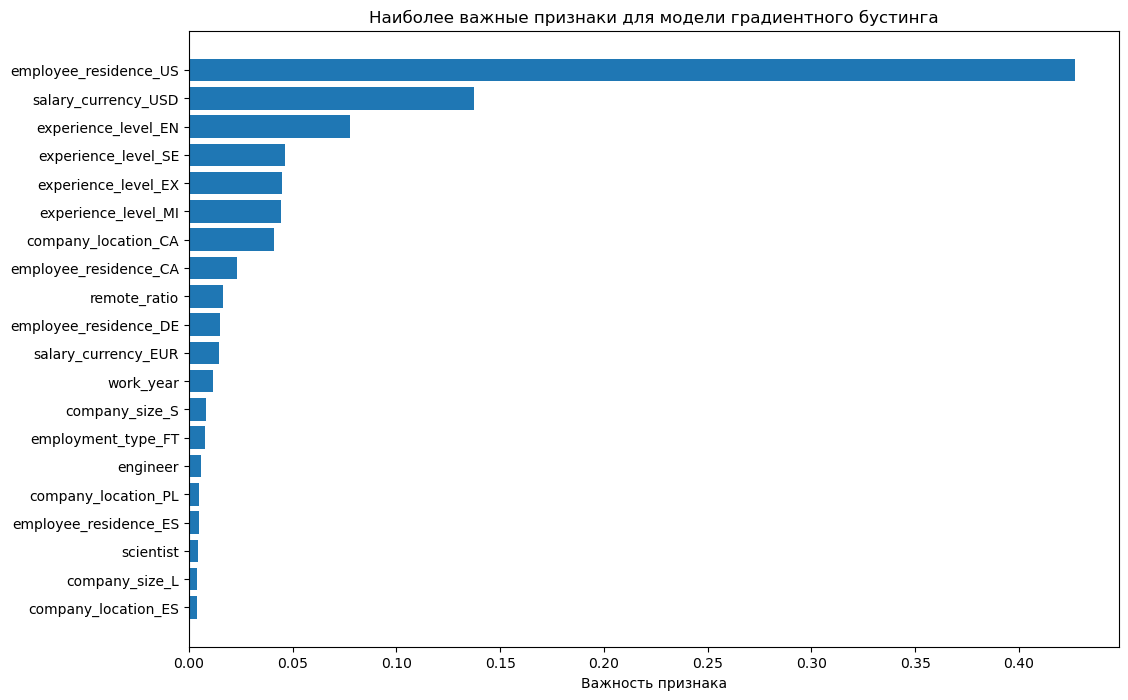

In [53]:
# Обучение модели градиентного бустинга на всех признаках
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# Получение важности признаков
importances = gbr.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 20
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_feature_names = X_train.columns[top_indices]

plt.figure(figsize=(12, 8))
plt.title("Наиболее важные признаки для модели градиентного бустинга")
plt.barh(range(top_n), top_importances, align="center")
plt.yticks(range(top_n), top_feature_names)
plt.xlabel("Важность признака")
plt.gca().invert_yaxis()  # Инвертировать ось y, чтобы на верхней позиции был наиболее важный признак
plt.show()


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Обучение лучшей модели с подбором гиперпараметров</h1> 

In [78]:
score_df = score_df.set_index('Model')
score_df_ = score_df[1:]
styled_df = score_df_.style.background_gradient(cmap='YlOrRd')
styled_df

,MAE (Train),RMSE (Train),R^2 (Train),MAE (Test),RMSE (Test),R^2 (Test)
Model,,,,,,
Linear Regression (PCA),35435.644847,44441.495143,0.354634,37128.927719,46323.940478,0.329956
Decision Tree (All Features),28225.594450,38912.385614,0.505229,39679.594354,49951.448407,0.220909
Decision Tree (PCA),28225.594450,38912.385614,0.505229,39287.796682,49221.715502,0.243506
Random Forest (All Features),30343.735541,39549.467968,0.488895,37320.498449,46831.748950,0.315185
Random Forest (PCA),30307.416001,39518.162202,0.489704,37337.643068,46814.842321,0.315680
Boosting (All Features),34213.857412,43125.387827,0.392292,36876.948604,46155.965946,0.334807
Boosting (PCA),32562.599435,41380.921285,0.440463,36976.908389,46459.125071,0.326040


* Наилучшей моделью оказался градиентный бустинг, обученный на всех признаках. Его и возьмём для более лучшего обучения с помошью байесовской оптимизации.

In [84]:
def evaluate_gbr(n_estimators, learning_rate, max_depth, min_samples_split, min_samples_leaf):
    model = GradientBoostingRegressor(
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # Возвращаем rmse с минусом, потому что, чем оно меньше, тем лучше
    return -rmse

# Диапазоны гиперпараметров
param_ranges = {
    'n_estimators': (50, 500), #Количество деревьев
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 30),
    'min_samples_split': (2, 20), #Минимальное количество образцов, необходимых для разделения узла в дереве.
    'min_samples_leaf': (1, 20) #Минимальное количество образцов, которые должны быть в листьях дерева
}

optimizer = BayesianOptimization(
    f=evaluate_gbr,
    pbounds=param_ranges,
    random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

best_params = optimizer.max['params']
best_params = {
    'n_estimators': int(best_params['n_estimators']),
    'learning_rate': best_params['learning_rate'],
    'max_depth': int(best_params['max_depth']),
    'min_samples_split': int(best_params['min_samples_split']),
    'min_samples_leaf': int(best_params['min_samples_leaf'])
}

print(f"Наилучшие гиперпараметры: \n {best_params}")

best_gbr = GradientBoostingRegressor(**best_params, random_state=42)
best_gbr.fit(X_train, y_train)
y_pred_best = best_gbr.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"MAE модели с наилучшими гиперпараметрами: {mae_best:.4f}")
print(f"RMSE модели с наилучшими гиперпараметрами: {rmse_best:.4f}")
print(f"R2 модели с наилучшими гиперпараметрами: {r2_best:.4f}")


|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -4.717e+0 | 0.1186    | 28.67     | 14.91     | 12.78     | 120.2     |
| 2         | -4.629e+0 | 0.05524   | 4.568     | 17.46     | 12.82     | 368.6     |
| 3         | -4.667e+0 | 0.01597   | 29.19     | 16.82     | 5.822     | 131.8     |
| 4         | -4.671e+0 | 0.06319   | 11.21     | 10.97     | 9.775     | 181.1     |
| 5         | -4.708e+0 | 0.1874    | 6.766     | 6.551     | 8.595     | 255.2     |
| 6         | -4.699e+0 | 0.1065    | 8.729     | 15.42     | 3.554     | 449.4     |
| 7         | -4.784e+0 | 0.1609    | 8.446     | 8.922     | 13.19     | 446.8     |
| 8         | -4.647e+0 | 0.1438    | 5.707     | 18.21     | 14.09     | 370.9     |
| 9         | -4.625e+0 | 0.04426   | 3.0       | 14.61     | 16.19     | 362.2     |
| 10        | -4.659e+0 | 0.01      | 3.0       | 15.0